# Nettoyage du jeu de données "Open Facts Food"

In [1]:
# importation des librairies nécessaires

import numpy as np
import pandas as pd
import scipy.stats as stats
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# importation du jeu de données
filename = "openfoodfacts_data.csv"
df = dd.read_csv(filename, dtype='object', sep='\t')

In [3]:
# Transformation du dataframe Dask en dataframe Pandas
df = df.compute()

## 1) Traitement des valeurs manquantes

Toutes les colonnes où on observe un pourcentage supérieur à 75% sont supprimées du jeu de données. 

In [4]:
df = df.loc[:, df.isnull().mean() <.75]

In [5]:
# Affichage du pourcentage de donneés manquantes
df.isnull().mean() * 100

code                                        0.000000
url                                         0.000000
creator                                     0.000218
created_t                                   0.000000
created_datetime                            0.000000
last_modified_t                             0.000000
last_modified_datetime                      0.000000
product_name                                4.293625
quantity                                   74.530323
brands                                     48.288157
brands_tags                                48.291323
categories                                 52.415655
categories_tags                            52.415819
categories_en                              52.415819
countries                                   0.305666
countries_tags                              0.305939
countries_en                                0.305939
ingredients_text                           61.863617
serving_size                               73.

<AxesSubplot:>

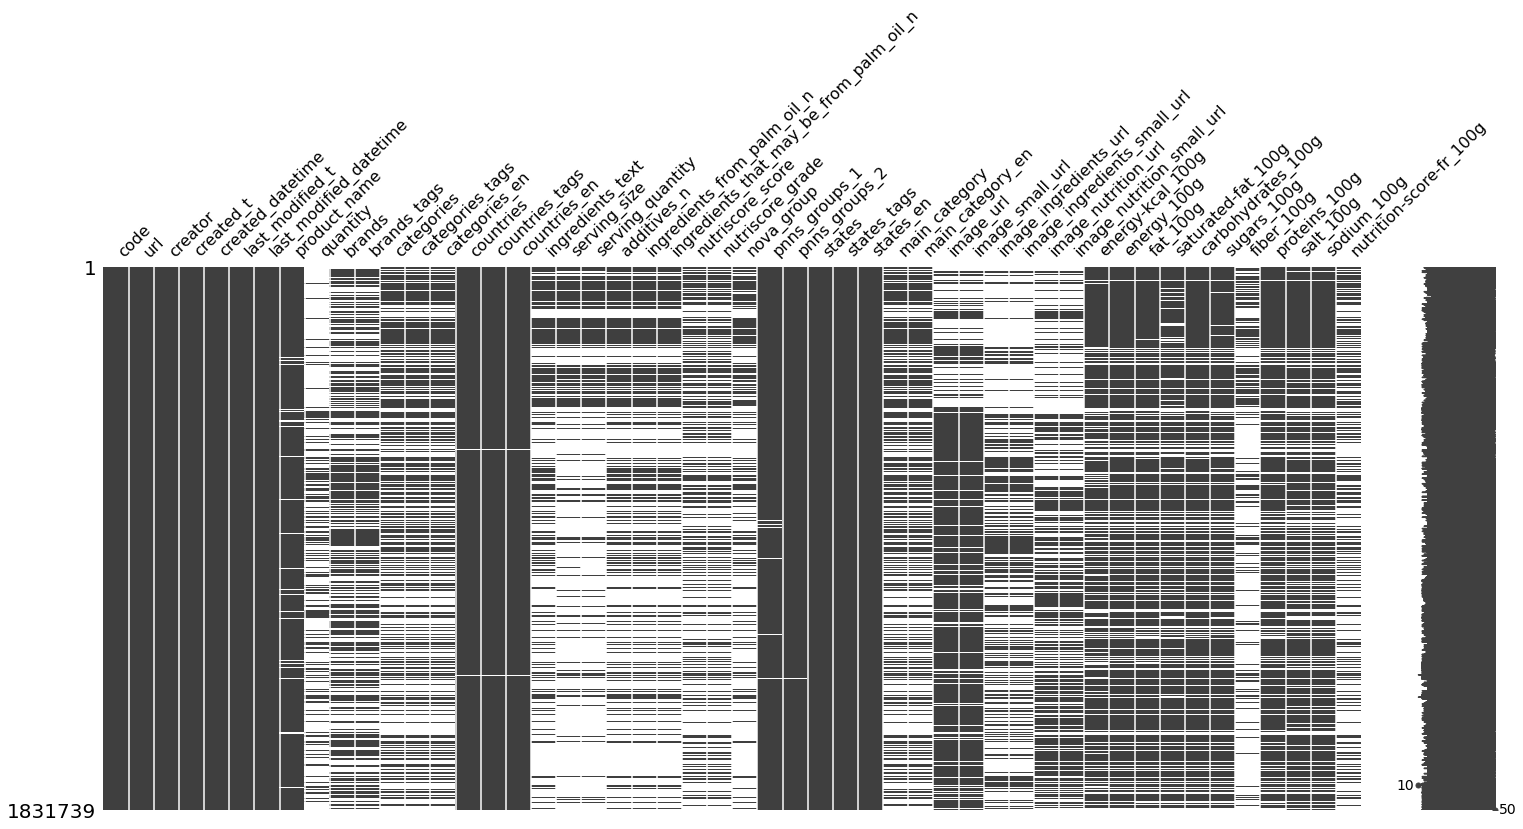

In [6]:
%matplotlib inline
msno.matrix(df)

In [7]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,endives,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,1569,7,3.08,70.1,15,NaN,7.8,1.4,0.56,NaN
2,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000004622327,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1619501895,2021-04-27T05:38:15Z,1619501897,2021-04-27T05:38:17Z,Hamburguesas de ternera 100%,NaN,NaN,...,3661,15.1,6.1,2.6,1,NaN,15.7,2.1,0.84,NaN


In [8]:
# modification des types du dataset en float quand cela est nécessaire
for col in df.columns:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1831739 entries, 0 to 8915
Data columns (total 50 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   code                                     object 
 1   url                                      object 
 2   creator                                  object 
 3   created_t                                int64  
 4   created_datetime                         object 
 5   last_modified_t                          int64  
 6   last_modified_datetime                   object 
 7   product_name                             object 
 8   quantity                                 object 
 9   brands                                   object 
 10  brands_tags                              object 
 11  categories                               object 
 12  categories_tags                          object 
 13  categories_en                            object 
 14  countries            

In [10]:
df.describe()

,created_t,last_modified_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,1.831739e+06,1.831739e+06,4.748770e+05,698560.000000,698560.000000,698560.000000,676376.000000,610302.000000,1.400772e+06,1.453609e+06,1.445528e+06,1.401935e+06,1.445073e+06,1.428125e+06,475375.000000,1.446634e+06,1.386020e+06,1.386016e+06,676380.000000
mean,1.554164e+09,1.589195e+09,2.339796e+16,2.041302,0.020594,0.069251,9.164110,3.430575,6.270043e+06,4.585524e+36,1.471549e+01,1.228900e+01,2.883424e+01,1.399855e+01,5.133826,8.776985e+00,2.881278e+00,1.152543e+00,9.164155
std,5.101789e+07,2.932132e+07,1.612378e+19,2.912968,0.143932,0.301304,8.871495,0.965099,7.346005e+09,5.528569e+39,8.551165e+02,8.445728e+03,6.444230e+02,8.370843e+02,1450.395241,1.454257e+02,8.603448e+02,3.441382e+02,8.871497
min,1.328021e+09,1.333873e+09,0.000000e+00,0.000000,0.000000,0.000000,-15.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02,0.000000e+00,0.000000e+00,-15.000000
25%,1.520953e+09,1.579543e+09,2.800000e+01,0.000000,0.000000,0.000000,2.000000,3.000000,1.010000e+02,4.180000e+02,7.700000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000,1.300000e+00,7.000000e-02,2.800000e-02,2.000000
50%,1.565630e+09,1.588445e+09,5.000000e+01,1.000000,0.000000,0.000000,10.000000,4.000000,2.610000e+02,1.084000e+03,7.000000e+00,1.800000e+00,1.508000e+01,3.570000e+00,1.600000,6.000000e+00,5.600000e-01,2.240000e-01,10.000000
75%,1.590418e+09,1.612604e+09,1.130000e+02,3.000000,0.000000,0.000000,16.000000,4.000000,4.000000e+02,1.674000e+03,2.140000e+01,7.140000e+00,5.300000e+01,1.800000e+01,3.600000,1.230000e+01,1.400000e+00,5.600000e-01,16.000000
max,1.623891e+09,1.623891e+09,1.111111e+22,49.000000,3.000000,6.000000,40.000000,4.000000,8.693855e+12,6.665559e+42,9.999990e+05,9.999999e+06,7.629390e+05,9.999990e+05,999999.000000,1.730000e+05,9.999990e+05,3.999996e+05,40.000000


In [11]:
df.shape

(1831739, 50)

Pour finir le traitement des valeurs manquantes, il faudra choisir entre plusieurs méthodes : 
- Enlever les valeurs manquantes (via la méthode dropna)
- Remplacer les valeurs manquantes avec la médiane
- Remplacer les valeurs manquantes avec la moyenne

Avant de procéder à cette étape, on va s'intéresser à deux autres points : le traitement des donneés dupliquées ainsi que l'étude des anomalies.

## 2) Traitement des données dupliquées

Il y a deux types de données dupliquées : 
- Celles qui correspondent à des colonnes dont les noms sont différents mais donnent la même information (les colonnes _en ou _tags par exemple)
- Celles que l'on peut enlever à l'aide des méthodes. duplicated() et .drop_duplicates()

Dans un premier temps, nous allons nous créer une liste avec les noms des colonnes à supprimer (avec le suffixe _en ou _tags). Ensuite, on cherchera à supprimer les données dupliquées à l'aide des méthodes spécifiques des dataframes Pandas. 

#### a) Suppression des colonnes redondantes

In [14]:
drop_cols = ["brands_tags", "categories_tags", "categories_en", "countries_tags", "countries_en", "states_tags", "states_en",
             "main_category_en", "image_small_url", "image_ingredients_small_url", "image_nutrition_small_url", "nutrition-score-fr_100g"]

In [15]:
df.drop(drop_cols, axis=1, inplace=True)

#### b) Suppression des informations dupliquées avec .drop_duplicates() et .duplicated()

In [16]:
dupl = df.duplicated()

In [17]:
df_dupl = df[dupl]
df_dupl.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
13367,7340011495437,http://world-en.openfoodfacts.org/product/7340...,halal-app-chakib,1610378294,2021-01-11T15:18:14Z,1610393709,2021-01-11T19:35:09Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df = df[~dupl]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,endives,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,375.0,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.4,0.56
2,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000004622327,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1619501895,2021-04-27T05:38:15Z,1619501897,2021-04-27T05:38:17Z,Hamburguesas de ternera 100%,NaN,NaN,...,874.9,3661.0,15.1,6.10,2.6,1.0,NaN,15.7,2.1,0.84


In [19]:
df.shape

(1831738, 38)

Le traitement des données dupliquées montre qu'il y a trois variables qui étaient dupliquées.

## Détection des outliers

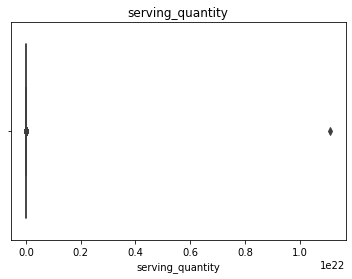

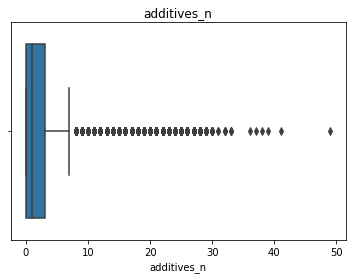

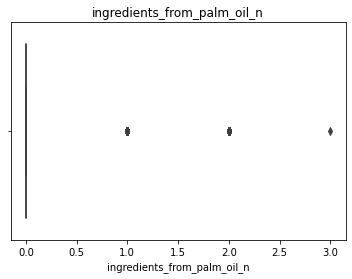

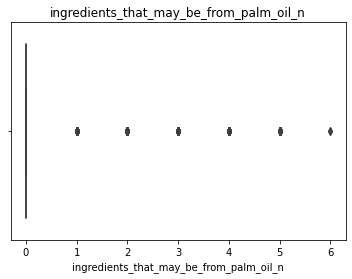

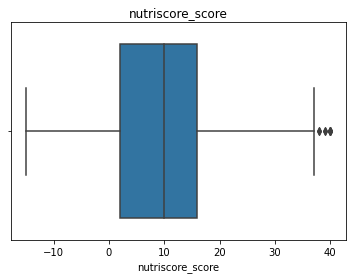

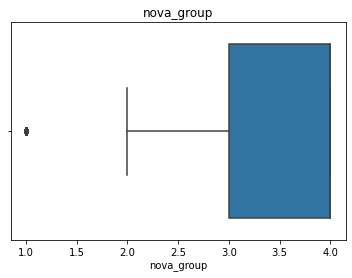

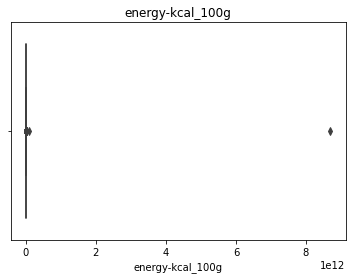

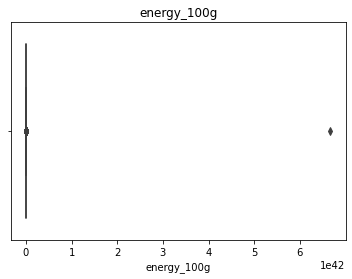

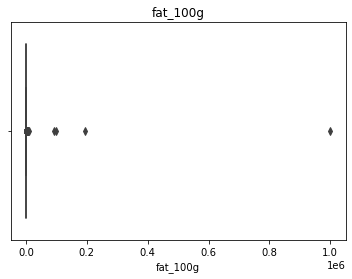

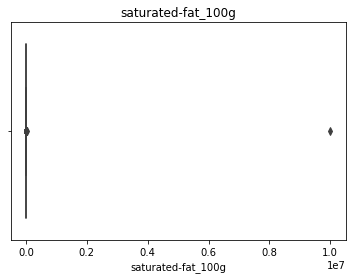

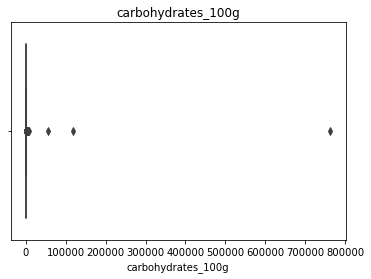

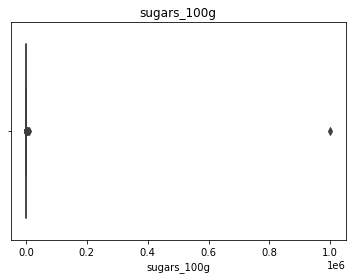

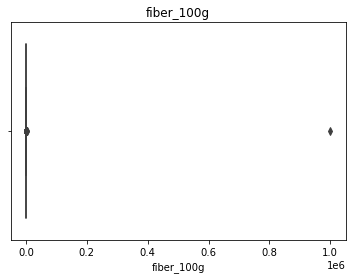

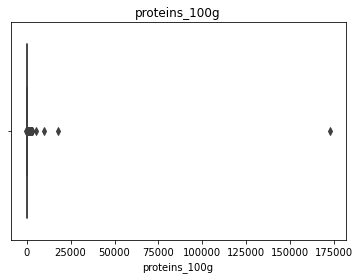

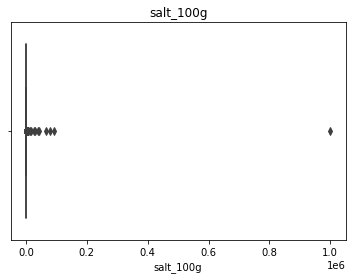

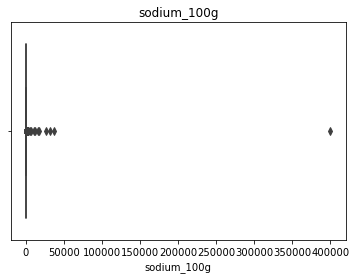

In [20]:
for var in df.columns:
    if df[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df)
        plt.title(var)
        plt.show()

## Traitement des outliers à l'aide de la médiane (IQR)

In [21]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(lower_bound)
print(upper_bound)

created_t                                  1.416756e+09
last_modified_t                            1.529950e+09
serving_quantity                          -9.950000e+01
additives_n                               -4.500000e+00
ingredients_from_palm_oil_n                0.000000e+00
ingredients_that_may_be_from_palm_oil_n    0.000000e+00
nutriscore_score                          -1.900000e+01
nova_group                                 1.500000e+00
energy-kcal_100g                          -3.475000e+02
energy_100g                               -1.466000e+03
fat_100g                                  -3.017500e+01
saturated-fat_100g                        -1.046000e+01
carbohydrates_100g                        -7.075000e+01
sugars_100g                               -2.550000e+01
fiber_100g                                -5.400000e+00
proteins_100g                             -1.520000e+01
salt_100g                                 -1.925000e+00
sodium_100g                               -7.700

In [22]:
import warnings
warnings.filterwarnings("ignore")

df_clean = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
df_clean.shape

(1216741, 38)

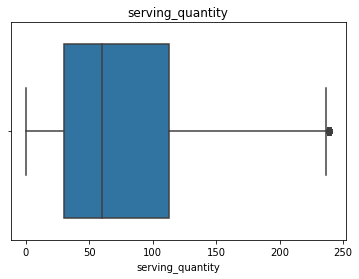

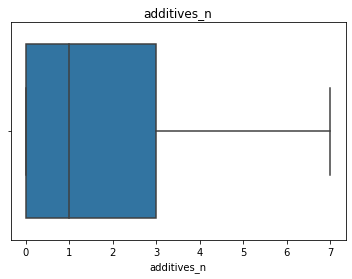

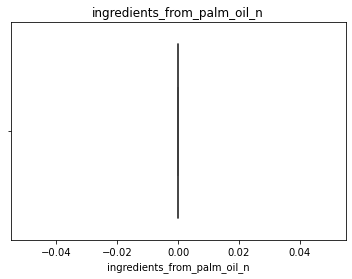

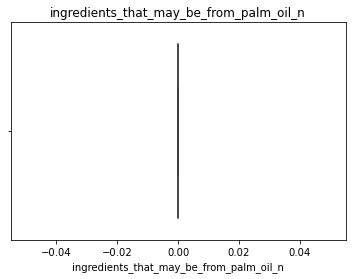

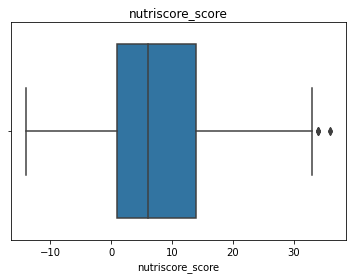

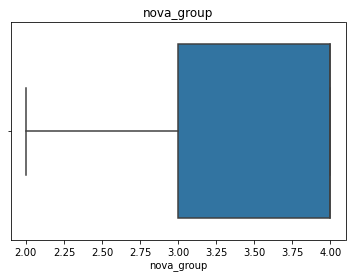

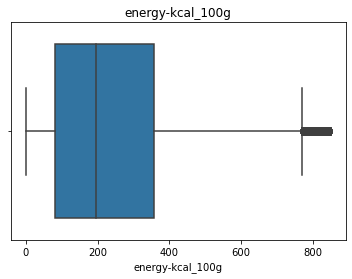

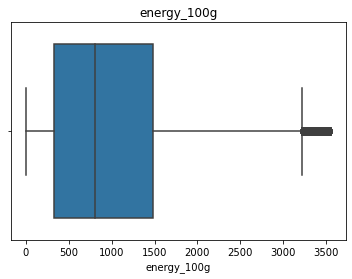

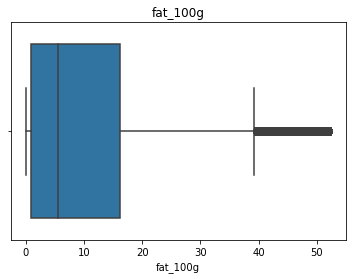

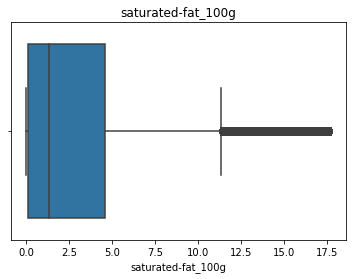

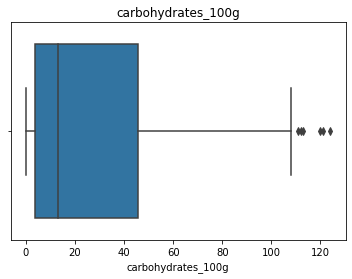

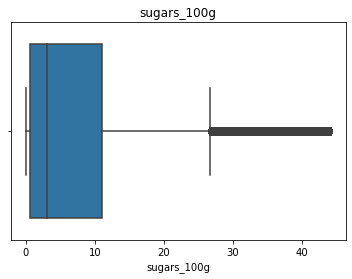

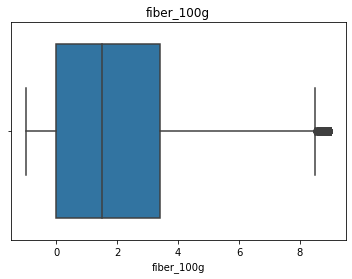

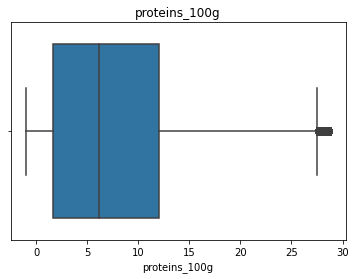

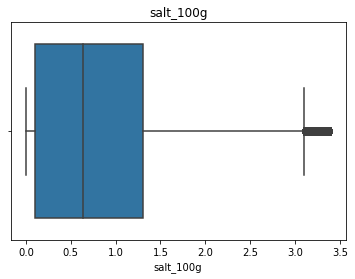

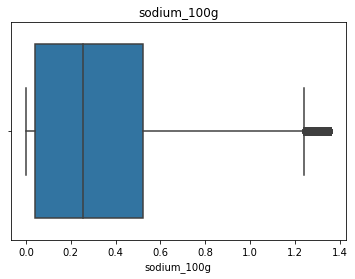

In [23]:
for var in df_clean.columns:
    if df_clean[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df_clean)
        plt.title(var)
        plt.show()

In [24]:
df_clean.describe()

,created_t,last_modified_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,1.216741e+06,1.216741e+06,223189.000000,336865.000000,336865.0,336865.0,369027.000000,282311.000000,852368.000000,872178.000000,865381.000000,854597.000000,865344.000000,862670.000000,233188.000000,866076.000000,829044.000000,829044.000000
mean,1.564047e+09,1.593400e+09,80.086836,1.596518,0.0,0.0,7.574700,3.704340,223.637367,932.516972,9.958238,3.208519,24.637241,8.051271,2.120515,7.807928,0.809412,0.323765
std,4.368227e+07,2.233818e+07,62.813909,1.890972,0.0,0.0,8.058874,0.473093,165.864136,692.544930,11.311672,4.234531,25.322979,10.747718,2.263569,7.065212,0.795146,0.318059
min,1.416758e+09,1.529950e+09,0.000000,0.000000,0.0,0.0,-14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000
25%,1.536742e+09,1.581369e+09,30.000000,0.000000,0.0,0.0,1.000000,3.000000,80.000000,331.000000,0.800000,0.100000,3.570000,0.600000,0.000000,1.666700,0.100000,0.040000
50%,1.572247e+09,1.594202e+09,60.000000,1.000000,0.0,0.0,6.000000,4.000000,194.000000,803.000000,5.500000,1.333300,13.100000,3.100000,1.500000,6.200000,0.637500,0.255000
75%,1.598979e+09,1.613556e+09,113.000000,3.000000,0.0,0.0,14.000000,4.000000,355.555556,1485.000000,16.200000,4.600000,45.700000,11.000000,3.400000,12.000000,1.300000,0.520000
max,1.623891e+09,1.623891e+09,240.000000,7.000000,0.0,0.0,36.000000,4.000000,848.000000,3548.000000,52.333333,17.700000,124.000000,44.099998,9.000000,28.800000,3.392857,1.357143


## Traitement des valeurs manquantes (suite)

Nos valeurs ont été nettoyées des données aberrantes et on se rend compte que l'index glycémique ne contient qu'une seule valeur. On va donc enlever cette variable de notre étude. Il existe deux variables qui rassemblent les données du nutriscore et elles sont identiques. On va donc en supprimer une pour éviter la redondance dans notre dataset. 

### Retrait des valeurs manquantes

In [25]:
df = df_clean.copy()

In [26]:
df_clean_no_na = df.dropna()

<AxesSubplot:>

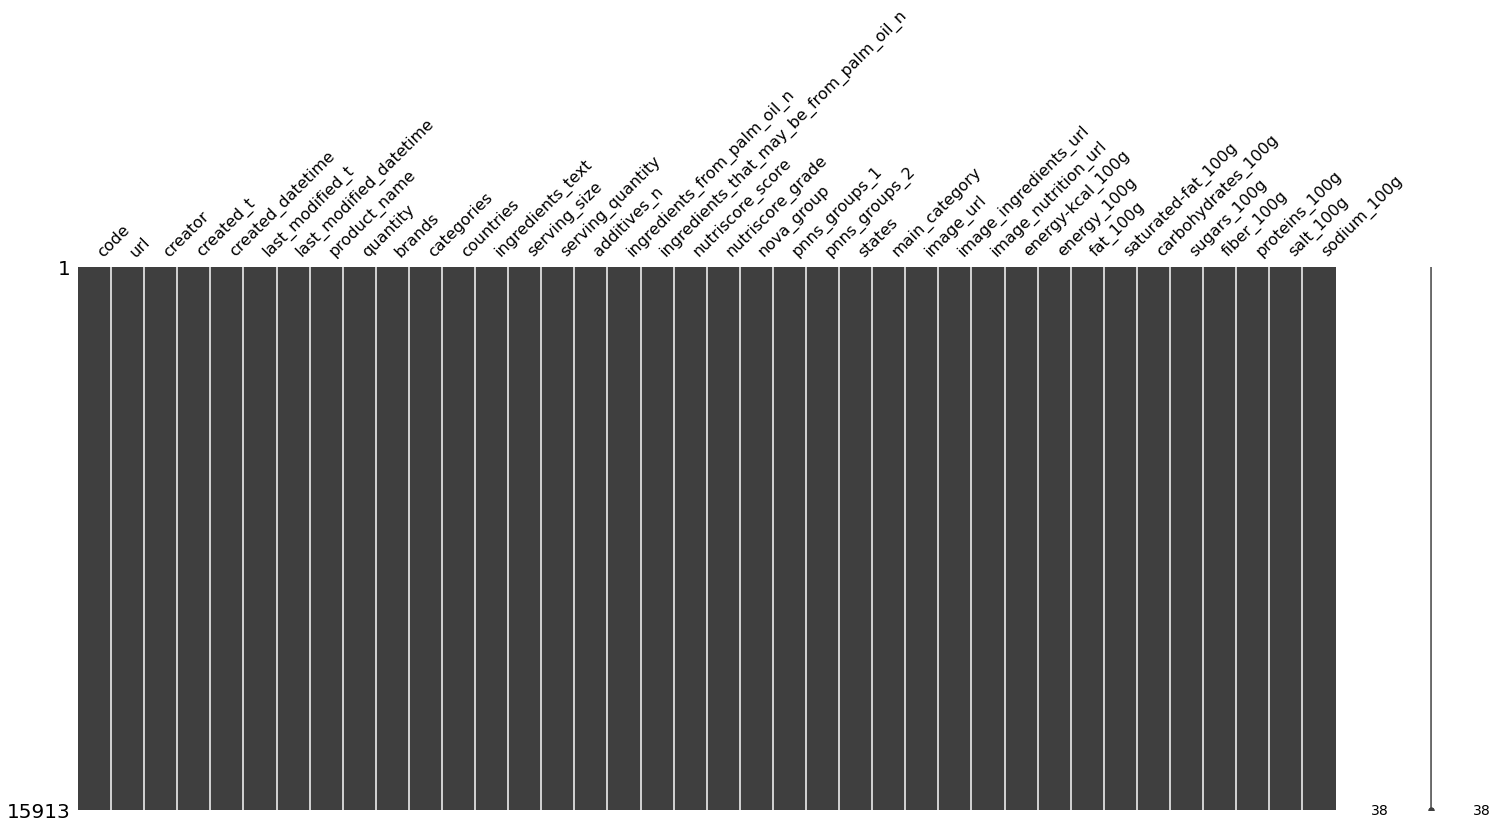

In [27]:
%matplotlib inline
msno.matrix(df_clean_no_na)

In [28]:
df_clean_no_na.describe()

,created_t,last_modified_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,1.591300e+04,1.591300e+04,15913.000000,15913.000000,15913.0,15913.0,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000,15913.000000
mean,1.516684e+09,1.603625e+09,78.438804,1.618802,0.0,0.0,6.283919,3.696977,256.037660,1065.427211,10.792606,3.298496,31.289436,9.760542,2.531657,7.328841,0.824918,0.329991
std,5.369308e+07,1.978482e+07,58.746794,1.759833,0.0,0.0,7.808251,0.461354,167.685498,699.333254,10.872294,4.074070,26.027462,11.073455,2.346767,5.746092,0.702939,0.281230
min,1.416759e+09,1.530207e+09,0.000000,0.000000,0.0,0.0,-14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.476206e+09,1.592822e+09,30.000000,0.000000,0.0,0.0,0.000000,3.000000,104.000000,431.000000,2.000000,0.400000,7.800000,1.410000,0.500000,3.100000,0.170000,0.068000
50%,1.515763e+09,1.612887e+09,63.000000,1.000000,0.0,0.0,5.000000,4.000000,233.000000,966.000000,7.000000,1.750000,22.300000,4.400000,2.000000,6.450000,0.730000,0.292000
75%,1.560442e+09,1.617140e+09,110.000000,3.000000,0.0,0.0,12.000000,4.000000,408.000000,1702.000000,17.110000,4.400000,55.000000,15.100000,4.000000,9.700000,1.250000,0.500000
max,1.623846e+09,1.623885e+09,240.000000,7.000000,0.0,0.0,30.000000,4.000000,831.000000,3406.000000,52.100000,17.700000,113.000000,44.000000,9.000000,28.600000,3.392857,1.357143


In [29]:
df_clean_no_na.to_csv("openfoodfacts_clean.csv", index=False)

### Remplacement des valeurs manquantes par la valeur médiane

### Remplacement des valeurs manquantes par la valeur moyenne